In [3]:
%matplotlib inline


`Learn the Basics <intro.html>`_ ||
**Quickstart** ||
`Tensors <tensorqs_tutorial.html>`_ ||
`Datasets & DataLoaders <data_tutorial.html>`_ ||
`Transforms <transforms_tutorial.html>`_ ||
`Build Model <buildmodel_tutorial.html>`_ ||
`Autograd <autogradqs_tutorial.html>`_ ||
`Optimization <optimization_tutorial.html>`_ ||
`Save & Load Model <saveloadrun_tutorial.html>`_

Quickstart
===================
This section runs through the API for common tasks in machine learning. Refer to the links in each section to dive deeper.

Working with data
-----------------
PyTorch has two `primitives to work with data <https://pytorch.org/docs/stable/data.html>`_:
``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``.
``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around
the ``Dataset``.


In [4]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

PyTorch offers domain-specific libraries such as `TorchText <https://pytorch.org/text/stable/index.html>`_,
`TorchVision <https://pytorch.org/vision/stable/index.html>`_, and `TorchAudio <https://pytorch.org/audio/stable/index.html>`_,
all of which include datasets. For this tutorial, we  will be using a TorchVision dataset.

The ``torchvision.datasets`` module contains ``Dataset`` objects for many real-world vision data like
CIFAR, COCO (`full list here <https://pytorch.org/vision/stable/datasets.html>`_). In this tutorial, we
use the FashionMNIST dataset. Every TorchVision ``Dataset`` includes two arguments: ``transform`` and
``target_transform`` to modify the samples and labels respectively.



In [5]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100.0%


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports
automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element
in the dataloader iterable will return a batch of 64 features and labels.



In [6]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Mostremos algunas imagenes




numeric labels: tensor([9, 2, 1, 1, 6])


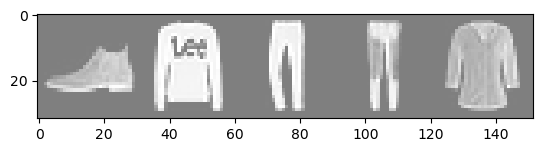

In [7]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5 # aclaramos la imagen
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

mi_loader = DataLoader(test_data, batch_size=5)

iterador =  iter(mi_loader)

primera_tanda = next(iterador)

imshow(make_grid(primera_tanda[0]))
print("numeric labels:",primera_tanda[1])

--------------




Creating Models
------------------
To define a neural network in PyTorch, we create a class that inherits
from `nn.Module <https://pytorch.org/docs/stable/generated/torch.nn.Module.html>`_. We define the layers of the network
in the ``__init__`` function and specify how data will pass through the network in the ``forward`` function. To accelerate
operations in the neural network, we move it to the GPU if available.



In [8]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        # estilo Python 2
        super(NeuralNetwork, self).__init__()
        # estilo Python 3
        # super().__init__()
        # transforma la imagen de 28x28 a 1x784
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Read more about `building neural networks in PyTorch <buildmodel_tutorial.html>`_.




--------------




Optimizing the Model Parameters
----------------------------------------
To train a model, we need a `loss function <https://pytorch.org/docs/stable/nn.html#loss-functions>`_
and an `optimizer <https://pytorch.org/docs/stable/optim.html>`_.



In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and
backpropagates the prediction error to adjust the model's parameters.



In [10]:
# ? debugging ver memoria gpu usada
# import torch.cuda as cutorch
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # ? ver memoria usada por la gpu antes.
        #print(cutorch.memory_allocated(device=device))
        X, y = X.to(device), y.to(device)
        # ? ver memoria de la gpu usda despues de cargar los datos.
        # print(cutorch.memory_allocated(device=device))
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also check the model's performance against the test dataset to ensure it is learning.



In [11]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (*epochs*). During each epoch, the model learns
parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the
accuracy increase and the loss decrease with every epoch.



In [15]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.653318  [    0/60000]
loss: 0.743072  [ 6400/60000]
loss: 0.518148  [12800/60000]
loss: 0.746764  [19200/60000]
loss: 0.659197  [25600/60000]
loss: 0.642440  [32000/60000]
loss: 0.707557  [38400/60000]
loss: 0.724796  [44800/60000]
loss: 0.714585  [51200/60000]
loss: 0.679700  [57600/60000]
Test Error: 
 Accuracy: 76.2%, Avg loss: 0.674417 

Epoch 2
-------------------------------
loss: 0.632993  [    0/60000]
loss: 0.724067  [ 6400/60000]
loss: 0.501481  [12800/60000]
loss: 0.733442  [19200/60000]
loss: 0.647692  [25600/60000]
loss: 0.630576  [32000/60000]
loss: 0.690735  [38400/60000]
loss: 0.714006  [44800/60000]
loss: 0.702925  [51200/60000]
loss: 0.666328  [57600/60000]
Test Error: 
 Accuracy: 76.8%, Avg loss: 0.660723 

Epoch 3
-------------------------------
loss: 0.614505  [    0/60000]
loss: 0.706467  [ 6400/60000]
loss: 0.486461  [12800/60000]
loss: 0.721008  [19200/60000]
loss: 0.637440  [25600/60000]
loss: 0.619996  [32000/600

Read more about `Training your model <optimization_tutorial.html>`_.




--------------




Saving Models
-------------
A common way to save a model is to serialize the internal state dictionary (containing the model parameters).



In [16]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


Loading Models
----------------------------

The process for loading a model includes re-creating the model structure and loading
the state dictionary into it.



In [17]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

This model can now be used to make predictions.



In [25]:
"""
⁡⁢⁣⁢IMPORTANTE⁡
No podes ejecutar este codigo saltandote la parte de ⁡⁣⁣⁢re instanciar el modelo⁡, ya que el modelo de entrenamiento
podra estar usando GPU, y aca hacemos una prediccion de un escalar, que ⁡⁣⁣⁢no esta en GPU.⁡
para usarlo con GPU tendrias que convertir el escalar en un tensor y moverlo a GPU, y todo ese tiempo perdido 
para evaluar una sola prediccion es un desperdicio de tiempo.
"""

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


Read more about `Saving & Loading your model <saveloadrun_tutorial.html>`_.




In [30]:
from torch.profiler import profile, record_function, ProfilerActivity

# Ver el rendimiento en cpu

model.eval()
x, y = test_data[0][0], test_data[0][1]

with profile(activities=[ProfilerActivity.CPU],profile_memory=True, record_shapes=True) as prof:
    with record_function("model_inference"):
        with torch.no_grad():
            pred = model(x)
            predicted, actual = classes[pred[0].argmax(0)], classes[y]
            print(f'Predicted: "{predicted}", Actual: "{actual}"')

print(prof.key_averages().table())
# exportar y se puede ver yendo a chrome en la URL chrome://tracing
prof.export_chrome_trace("trace.json")



Predicted: "Ankle boot", Actual: "Ankle boot"
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  aten::zeros         2.72%      15.000us         8.89%      49.000us      49.000us           4 b           0 b             1  
                  aten::empty         5.99%      33.000us         5.99%      33.000us      16.500us         268 b         268 b             2  
                  aten::zero_         0.36%       2.000us         0.36%       2.000us       2.000us           0 b           0 b             1  
              model_inference        25.59%     141.000us        91.11%     502.000us     